In [1]:
import requests
import json
import numpy as np
from ES import ES as es
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("testapp")
sc = SparkContext(conf=conf)
spark = SparkSession.builder \
    .master("local") \
    .appName("testapp") \
    .getOrCreate()

In [2]:
sc.version

'2.4.5'

In [3]:
lines = sc.textFile("README.md")
lineLengths = lines.map(lambda s: len(s))
totalLength = lineLengths.reduce(lambda a, b: a + b)

In [4]:
for ln in lines.take(20):
    print(ln)

# Spark-Pipelines

## Setup
1) Install docker to run spark notebook server https://www.docker.com/
2) Copy the example config and enter elasticsearch uri
```
$ cp config.json.example config.json
```
3) Start spark server
```
$ ./start.sh
```
4) Copy the local url that is printed to the command line into the browser



In [5]:
query = {
            "size": 10000,
             "query": {
                "bool": {
                    "must": [
                        {
                            "term": {
                                "enhancement.IDENTIFIERS.SIGNATURE_ID": {
                                    "value": "198"
                                }
                            }
                        },
                        {
                            "range": {
                                "pipeline.lambda": {
                                    "gte": "2019-01-01T00:00:52Z"
                                }
                            }
                        },
                        {
                            "term": {
                                "application_id": {
                                    "value": "3"
                                }
                            }
                        },
                        {
                            "term": {
                                "property_state": {
                                    "value": "CO"
                                }
                            }
                        }
                    ]
                }
             }
        }

In [6]:
db = es()

In [7]:
response = db.get_data_from_ES_prod_scroll(query)

scroll_size: 3161


In [8]:
prop_list = []
for i in range(len(response)):
    for j in range(len(response[i]['hits']['hits'])):
        prop_list.append(response[i]['hits']['hits'][j])

In [9]:
print(len(prop_list))

3161


In [10]:
prop_rdd = sc.parallelize(prop_list)

In [11]:
prop_rdd.count()

3161

In [12]:
def feature_builder(x):
    def cleaner(z):
        return 0 if z is None else z

    prop_lat =      float(cleaner(x.get('_source', {}).get('prop_latitude', 0.0)))
    prop_lon =      float(cleaner(x.get('_source', {}).get('prop_longitude', 0.0)))
    listing_price = float(cleaner(x.get('_source', {}).get('prop_listprice_i', 0.0)))
    sold_price =    float(cleaner(x.get('_source', {}).get('sold_price', 0.0)))
    acres =         float(cleaner(x.get('_source', {}).get('prop_acres', 0.0)))
    year_built =    int(cleaner(x.get('_source', {}).get('prop_yearbuilt', 0)))
    baths =         int(cleaner(x.get('_source', {}).get('total_baths', 0)))
    beds =          int(cleaner(x.get('_source', {}).get('prop_beds', 0)))
    
    feature_row = Row(
        prop_lat=prop_lat,
        prop_lon=prop_lon,
        sold_price=sold_price,
        year_built=year_built,
        baths=baths,
        beds=beds,
        acres=acres,
        listing_price=listing_price,
        label=sold_price

    )
    return feature_row

In [13]:
prop_feature_rdd = prop_rdd.map(lambda x: feature_builder(x))
prop_feature_rdd.take(5)

[Row(acres=0.17, baths=2, beds=3, label=0.0, listing_price=321516.0, prop_lat=40.384314, prop_lon=-104.749922, sold_price=0.0, year_built=2017),
 Row(acres=0.18, baths=3, beds=4, label=0.0, listing_price=339500.0, prop_lat=40.348488, prop_lon=-104.715364, sold_price=0.0, year_built=2004),
 Row(acres=3.7, baths=2, beds=4, label=0.0, listing_price=585000.0, prop_lat=40.44782, prop_lon=-105.045673, sold_price=0.0, year_built=1920),
 Row(acres=0.0, baths=2, beds=2, label=0.0, listing_price=699000.0, prop_lat=40.022659, prop_lon=-105.282547, sold_price=0.0, year_built=1984),
 Row(acres=1.06, baths=0, beds=0, label=0.0, listing_price=1150000.0, prop_lat=40.18314, prop_lon=-105.103116, sold_price=0.0, year_built=1963)]

In [14]:
prop_df = spark.createDataFrame(prop_feature_rdd)

In [15]:
prop_df.show()

+-----+-----+----+-----+-------------+---------+-----------+----------+----------+
|acres|baths|beds|label|listing_price| prop_lat|   prop_lon|sold_price|year_built|
+-----+-----+----+-----+-------------+---------+-----------+----------+----------+
| 0.17|    2|   3|  0.0|     321516.0|40.384314|-104.749922|       0.0|      2017|
| 0.18|    3|   4|  0.0|     339500.0|40.348488|-104.715364|       0.0|      2004|
|  3.7|    2|   4|  0.0|     585000.0| 40.44782|-105.045673|       0.0|      1920|
|  0.0|    2|   2|  0.0|     699000.0|40.022659|-105.282547|       0.0|      1984|
| 1.06|    0|   0|  0.0|    1150000.0| 40.18314|-105.103116|       0.0|      1963|
|  0.0|    1|   1|  0.0|     499000.0|40.015093|-105.246062|       0.0|      2007|
|  1.0|    0|   0|  0.0|      49000.0|40.395739|-104.047024|       0.0|         0|
|  0.2|    0|   0|  0.0|      25000.0|40.226111|-104.068007|       0.0|         0|
|  2.2|    3|   4|  0.0|     299900.0|40.116489| -104.00369|       0.0|      2001|
| 0.

In [16]:
clean_prop_df = prop_df.filter(prop_df.sold_price != 0.0).filter(prop_df.year_built != 0).filter(prop_df.beds != 0).filter(prop_df.baths != 0)

In [17]:
clean_prop_df.show()

+-----+-----+----+--------+-------------+---------+-----------+----------+----------+
|acres|baths|beds|   label|listing_price| prop_lat|   prop_lon|sold_price|year_built|
+-----+-----+----+--------+-------------+---------+-----------+----------+----------+
| 0.13|    4|   5|635000.0|     644900.0|39.388783|-107.208232|  635000.0|      1998|
|0.015|    2|   2|175000.0|     189900.0| 38.92929|-104.834618|  175000.0|      1984|
|0.161|    2|   3|492300.0|     497300.0|38.856306|-104.907367|  492300.0|      2002|
|1.432|    3|   3|899900.0|     899900.0| 38.99156|-105.041416|  899900.0|      2016|
|0.172|    2|   4|385000.0|     385000.0|38.854924| -104.81194|  385000.0|      1930|
|0.178|    3|   3|422500.0|     435000.0|39.086479|-104.853298|  422500.0|      2009|
| 0.52|    2|   3|285000.0|     295000.0|38.477249|-105.244151|  285000.0|      2001|
|0.167|    4|   4|455000.0|     455000.0|38.981421|-104.602315|  455000.0|      2004|
|0.189|    2|   4|237000.0|     275000.0|38.848105|-10

In [18]:
clean_prop_df.count()

2462

In [19]:
clean_prop_df.describe(['acres', 'baths', 'beds', 'sold_price', 'year_built']).show()

+-------+------------------+-----------------+------------------+-----------------+------------------+
|summary|             acres|            baths|              beds|       sold_price|        year_built|
+-------+------------------+-----------------+------------------+-----------------+------------------+
|  count|              2462|             2462|              2462|             2462|              2462|
|   mean|  1.06246466287571|3.065800162469537|3.3407798537774167|591886.6177904143|1990.4248578391553|
| stddev|10.601819673386618|1.285264907020724|1.1486588654705956|740604.1907683788| 21.27238261142315|
|    min|               0.0|                1|                 1|            895.0|              1888|
|    max|            345.68|               11|                 8|           1.35E7|              2019|
+-------+------------------+-----------------+------------------+-----------------+------------------+



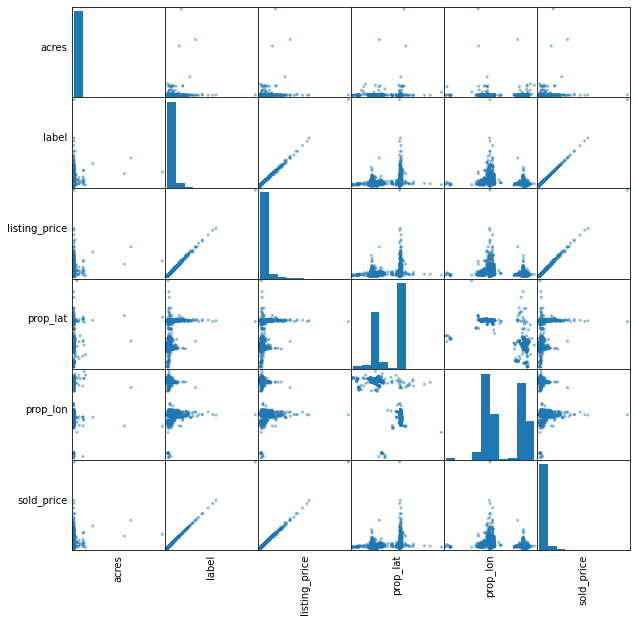

In [20]:
import pandas as pd
numeric_features = [t[0] for t in clean_prop_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = clean_prop_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [21]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(
    inputCols = ['prop_lat', 'prop_lon', 'listing_price', 'year_built', 'baths', 'beds', 'acres'], 
    outputCol = 'features')
feature_label_df = vectorAssembler.transform(clean_prop_df)
feature_label_df.show(3)

+-----+-----+----+--------+-------------+---------+-----------+----------+----------+--------------------+
|acres|baths|beds|   label|listing_price| prop_lat|   prop_lon|sold_price|year_built|            features|
+-----+-----+----+--------+-------------+---------+-----------+----------+----------+--------------------+
| 0.13|    4|   5|635000.0|     644900.0|39.388783|-107.208232|  635000.0|      1998|[39.388783,-107.2...|
|0.015|    2|   2|175000.0|     189900.0| 38.92929|-104.834618|  175000.0|      1984|[38.92929,-104.83...|
|0.161|    2|   3|492300.0|     497300.0|38.856306|-104.907367|  492300.0|      2002|[38.856306,-104.9...|
+-----+-----+----+--------+-------------+---------+-----------+----------+----------+--------------------+
only showing top 3 rows



In [22]:
splits = feature_label_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [23]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [21500.430265930383,9070.573229106063,0.9374539762794989,77.45948674237222,1139.5980732313492,-5679.121593241336,-519.0729760658636]
Intercept: -8127.300898123857


In [24]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 50895.599226
r2: 0.994803


In [25]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","label","features").show(10)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="label",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+---------+--------------------+
|        prediction|    label|            features|
+------------------+---------+--------------------+
| 264541.3109664302| 249000.0|[39.657988,-106.8...|
| 186501.3565558712| 150000.0|[39.632311,-106.2...|
|1153221.1445071136|1150000.0|[39.639252,-106.3...|
| 26839.12853492465|   1325.0|[38.922667,-104.7...|
|28141.455810410855|   4000.0|[39.605504,-106.5...|
| 193710.9780962287| 196000.0|[39.408578,-107.1...|
|436889.22122152196| 435000.0|[39.639703,-106.8...|
| 628122.7578511507| 620000.0|[39.639562,-106.5...|
|  72122.3133221084|  52000.0|[38.903907,-104.7...|
|330531.65286824544| 314000.0|[39.604097,-106.5...|
+------------------+---------+--------------------+
only showing top 10 rows

R Squared (R2) on test data = 0.997415


In [26]:
lr_predictions.select("listing_price", "label", "prediction").show()

+-------------+---------+------------------+
|listing_price|    label|        prediction|
+-------------+---------+------------------+
|     254000.0| 249000.0| 264541.3109664302|
|     175000.0| 150000.0| 186501.3565558712|
|    1200000.0|1150000.0|1153221.1445071136|
|       1325.0|   1325.0| 26839.12853492465|
|       5000.0|   4000.0|28141.455810410855|
|     199900.0| 196000.0| 193710.9780962287|
|     448000.0| 435000.0|436889.22122152196|
|     649000.0| 620000.0| 628122.7578511507|
|      48900.0|  52000.0|  72122.3133221084|
|     324000.0| 314000.0|330531.65286824544|
|     429900.0| 425000.0| 431774.4817859917|
|     625000.0| 620000.0| 614671.7525581218|
|      29000.0|  25000.0| 50103.65556270979|
|      99750.0| 102750.0|116251.31414873403|
|     189900.0| 175000.0|200574.40319237896|
|     250000.0| 243000.0|250332.41502976458|
|     369000.0| 365000.0| 373341.0716888966|
|     529000.0| 525000.0| 518240.0829155189|
|      12000.0|  12000.0|29014.130591604695|
|      135

In [27]:
data = lr_predictions.select("listing_price", "label", "prediction").collect()

In [28]:
data_dicts = [r.asDict() for r in data]

In [29]:
def per_diff(x):
    return abs(x['label']-x['prediction'])*100.0/x['label']
for d in data_dicts:
    d['per_diff'] = per_diff(d)

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

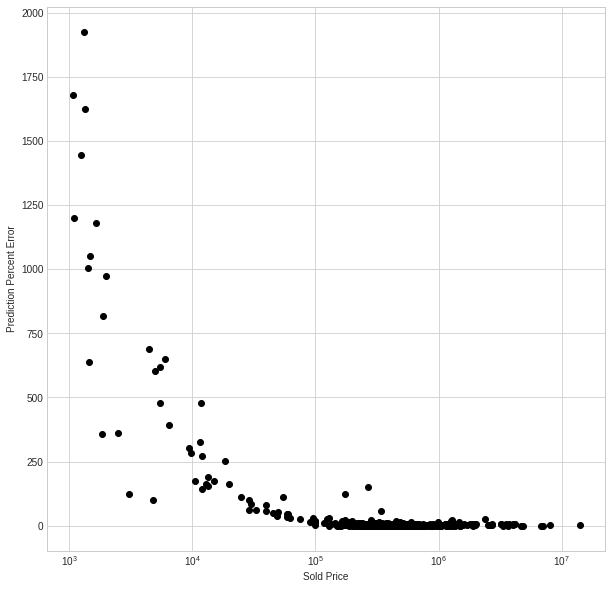

In [31]:
x = [d['listing_price'] for d in data_dicts]
y = [d['per_diff'] for d in data_dicts]
plt.figure(figsize=(10,10))
plt.semilogx(x, y, 'o', color='black')
plt.xlabel("Sold Price")
plt.ylabel("Prediction Percent Error")
plt.show()